In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
#######
DATA_FNAME = '/data/delon/LensQuEst/map_sims.pkl'

preload=False
import warnings
warnings.filterwarnings("ignore")
#####

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 400 # 1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [6]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [7]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


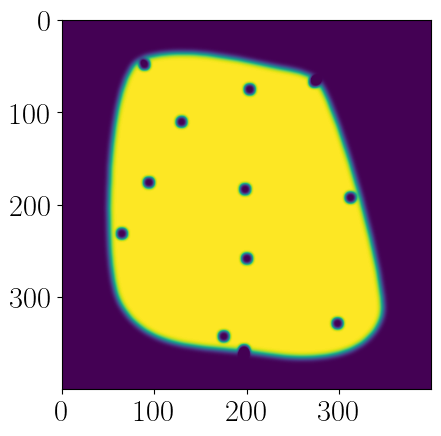

In [9]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread('mask_simple%dx%d.png'%(nX, nY)))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread('point_sources_bigger.png'))
point_sources = gaussian_filter(point_sources, 1.5) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)
# plt.imshow(apodized_mask)

In [ ]:
f = open(DATA_FNAME, 'rb') 
data = pickle.load(f) 
f.close()
for key in data:
    print(key, np.shape(data[key]))


In [17]:
# from tqdm import trange,tqdm 
# import pickle

# from itertools import product

# N_RUNS = 2
# poss = list(product([True, False], range(N_RUNS)))

# data = {}
# if(preload):
#     f = open(DATA_FNAME, 'rb') 
#     data = pickle.load(f) 
#     f.close()
#     for key in data:
#         print(key, np.shape(data[key]))

# for LENSED, run_n in tqdm(poss):
#     post_fix = '_%d'%(LENSED)

#     c_Data = {}
#     c_Data['cmb0F'+post_fix] = None
#     c_Data['kCmbF'+post_fix] = None
#     c_Data['lCmbF'+post_fix] = None
#     for i in range(1,5):
#         c_Data['lCmbF_o%d'%(i)+post_fix] = None
#     c_Data['fgF'+post_fix] = None
#     c_Data['noiseF'+post_fix] = None
#     c_Data['totalF'+post_fix] = None
#     c_Data['totalF_M'+post_fix] = None

    
#     totalCmbFourier, totalCmb = None, None
    
#     if(not LENSED):
#         totalCmbFourier = baseMap.genGRF(cmb.ftotal)
#         totalCmb = baseMap.inverseFourier(totalCmbFourier)
        
#     elif(LENSED):
#         cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
#         cmb0 = baseMap.inverseFourier(cmb0Fourier)
#         c_Data['cmb0F'+post_fix] = cmb0Fourier
        
#         kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
#         kCmb = baseMap.inverseFourier(kCmbFourier)
#         c_Data['kCmbF'+post_fix] = kCmbFourier
        
#         for i in range(1,5):
#             lensedCmb = baseMap.doLensingTaylor(unlensed=cmb0, kappaFourier=kCmbFourier, order=i)
#             lensedCmbFourier = baseMap.fourier(lensedCmb)
#             c_Data['lCmbF_o%d'%(i)+post_fix] = lensedCmbFourier
            
#         lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
#         lensedCmbFourier = baseMap.fourier(lensedCmb)
#         c_Data['lCmbF'+post_fix] = lensedCmbFourier
        
#         fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
#         lensedCmbFourier = lensedCmbFourier + fgFourier
#         lensedCmb = baseMap.inverseFourier(lensedCmbFourier)
#         c_Data['fgF'+post_fix] = fgFourier

#         noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
#         totalCmbFourier = lensedCmbFourier + noiseFourier
#         totalCmb = baseMap.inverseFourier(totalCmbFourier)
#         c_Data['noiseF'+post_fix] = noiseFourier
        
#     c_Data['totalF'+post_fix] = totalCmbFourier

#     totalCmb = apodized_mask*totalCmb
#     totalCmbFourier = baseMap.fourier(totalCmb)
        
#     c_Data['totalF_M'+post_fix] = totalCmbFourier


#     for key in c_Data:
#         if(c_Data[key] is None):
#             continue
#         if(key not in data.keys()):
#             data[key] = np.array([c_Data[key]])
#         else:
#             data[key] = np.vstack((np.array([c_Data[key]]), data[key]))  
            
#     f = open(DATA_FNAME, 'wb') 
#     pickle.dump(data, f)
#     f.close()

100%|██████████| 4/4 [01:11<00:00, 17.88s/it]


In [116]:
cmb0Fourier = data['cmb0F_1'][1]

lensedCmbFourier_o1 = data['lCmbF_o1_1'][1] - cmb0Fourier

fgFourier = data['fgF_1'][1]
lensedCmbFourier_o0 = cmb0Fourier + fgFourier
lensedCmbFourier_o1 = lensedCmbFourier_o1 + fgFourier

noiseFourier = data['noiseF_1'][1]
totalCmbFourier_o0 = lensedCmbFourier_o0 + noiseFourier
totalCmbFourier_o1 = lensedCmbFourier_o1 + noiseFourier

totalCmbFourier_real = data['totalF_1'][1]

qT0T1 = baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, 
                                        lMin=lMin, lMax=lMax, 
                                        dataFourier=totalCmbFourier_o0,
                                       dataFourier2=totalCmbFourier_o1)
qT1T0 =  baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, 
                                        lMin=lMin, lMax=lMax, 
                                        dataFourier=totalCmbFourier_o1,
                                       dataFourier2=totalCmbFourier_o0)

qT1T1 =  baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, 
                                        lMin=lMin, lMax=lMax, 
                                        dataFourier=totalCmbFourier_o1,
                                       dataFourier2=totalCmbFourier_o1)

qT0T0 =  baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, 
                                        lMin=lMin, lMax=lMax, 
                                        dataFourier=totalCmbFourier_o0,
                                       dataFourier2=totalCmbFourier_o0)

QE =  baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, 
                                        lMin=lMin, lMax=lMax, 
                                        dataFourier=totalCmbFourier_real)

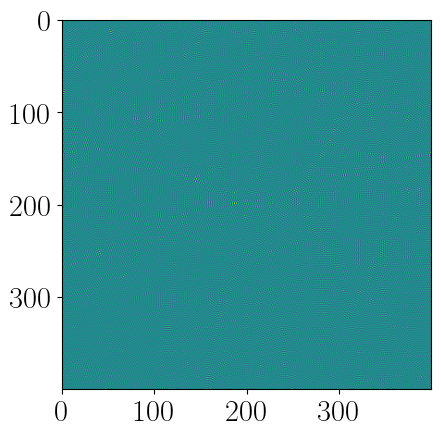

In [137]:
plt.imshow(baseMap.inverseFourier(QE))

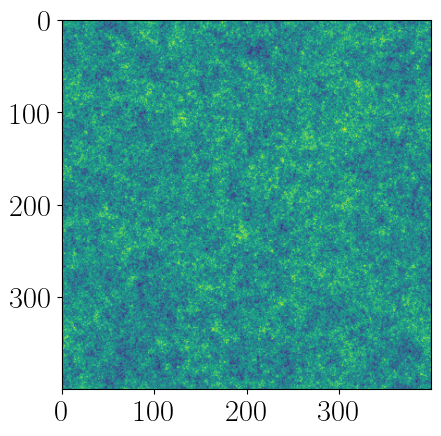

In [118]:
plt.imshow(baseMap.inverseFourier(data['kCmbF_1'][1]))

In [144]:
lCen, Cl, sCl = baseMap.powerSpectrum(dataFourier=qT0T0)
lCen2, Cl2, sCl2 = baseMap.powerSpectrum(dataFourier=qT0T1+qT1T0)

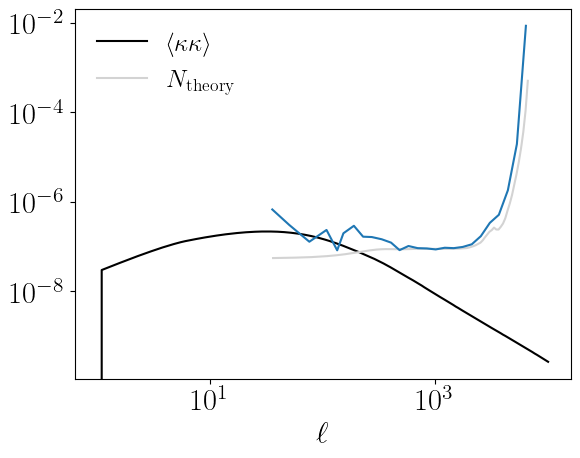

In [156]:
assert(all(lCen==lCen2))
Cl_tot = Cl2
ell = baseMap.l.flatten()

fig,ax = plt.subplots(nrows=1)
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, ClExpected, sty, label=l)

Ipos = np.where(Cl_tot>=1e-18)
ax.plot(lCen[Ipos], Cl_tot[Ipos])

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')


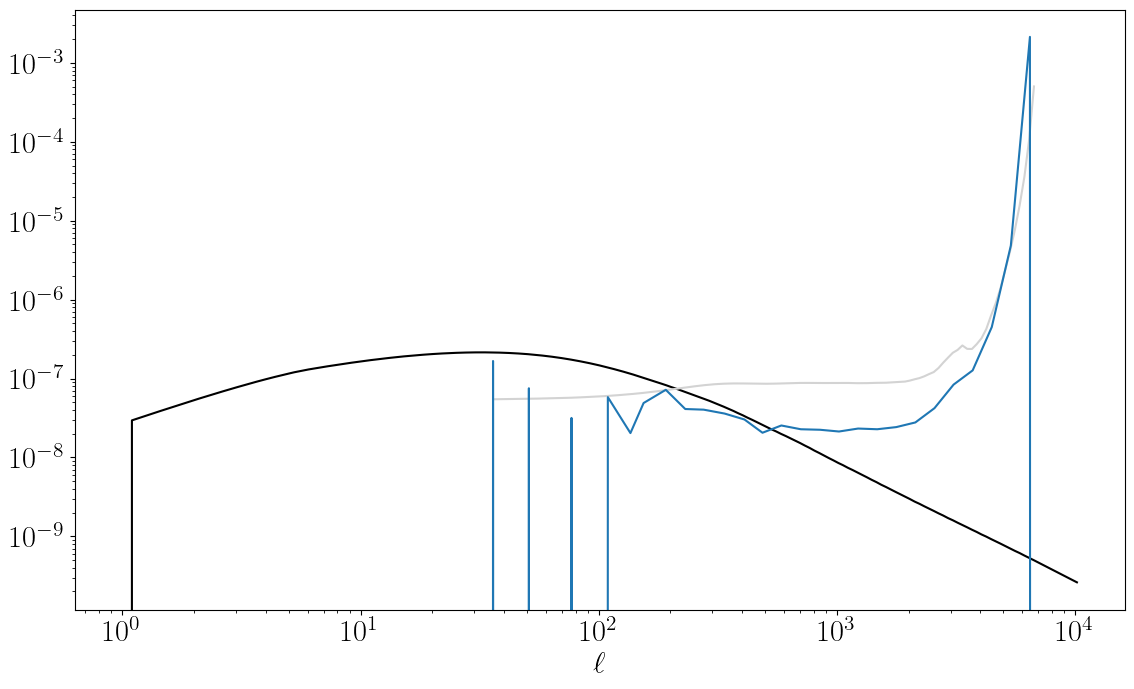

In [136]:
w = [0,0,0,0]
w[0] = baseMap.crossPowerSpectrum(dataFourier1=qT0T1,
                                  dataFourier2=qT1T0)
w[1] = baseMap.powerSpectrum(dataFourier=qT1T0)
w[2] = baseMap.crossPowerSpectrum(dataFourier1=qT1T0,
                                  dataFourier2=qT0T1)
w[3] = baseMap.powerSpectrum(dataFourier=qT0T1)

lCen = w[0][0]
Cl = sum(w[i][1] for i in range(4))/4

fig1 = plt.figure(figsize =(14, 10))

axs=[fig1.add_axes((0.2,0.4,.75,.6))]
ax=axs[0]

# fig.subplots_adjust(wspace=0, hspace=0)
ell = baseMap.l.flatten()

theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax_idx in range(len(axs)):
        ax = axs[ax_idx]
        if(ax_idx==1 and sty=='lightgrey'):
            continue
        ax.plot(L, ClExpected, sty, label=l)


ax.plot(lCen, (Cl))

ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')

In [32]:
for key in data:
    print(key)

cmb0F_1
kCmbF_1
lCmbF_1
lCmbF_o1_1
lCmbF_o2_1
lCmbF_o3_1
lCmbF_o4_1
fgF_1
noiseF_1
totalF_1
totalF_M_1
totalF_0
totalF_M_0


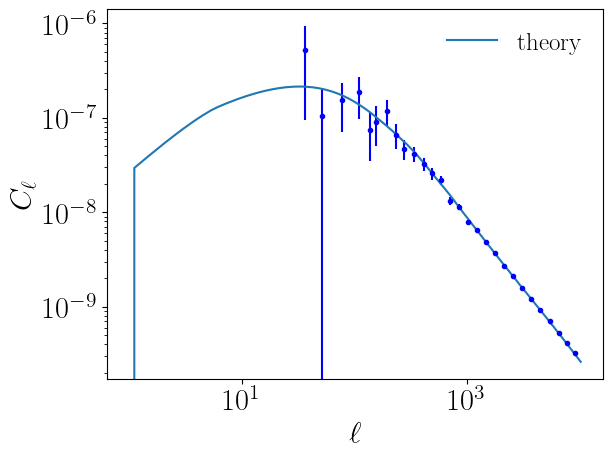

In [53]:
kCmbFourier = data['kCmbF_1'][1]
kCmb = baseMap.inverseFourier(kCmbFourier)
_,_,_ = baseMap.powerSpectrum(kCmbFourier, theory=[p2d_cmblens.fPinterp], plot=True, save=False)

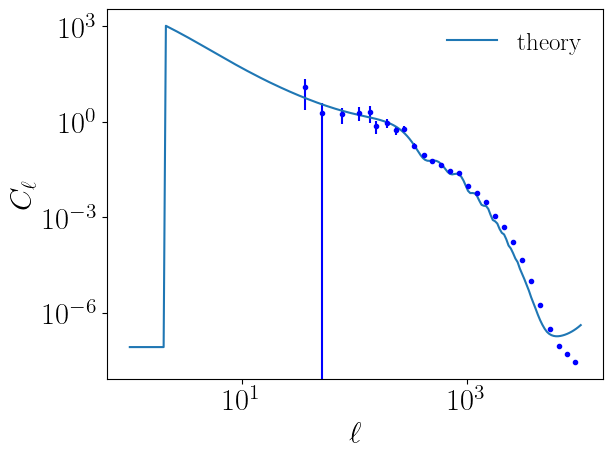

In [52]:
lensedCmbFourier = data['lCmbF_o1_1'][1]
lensedCmb = baseMap.inverseFourier(lensedCmbFourier)



_,_,_=baseMap.powerSpectrum(dataFourier=lensedCmbFourier, plot=True, theory=[lambda l: cmb.flensedTT(l) + cmb.fdetectorNoise(l)])

In [49]:
fgFourier = data['fgF_1'][1]
lensedCmbFourier = lensedCmbFourier + fgFourier
lensedCmb = baseMap.inverseFourier(lensedCmbFourier)

noiseFourier = data['noiseF_1'][1]
totalCmbFourier = lensedCmbFourier + noiseFourier
totalCmb = baseMap.inverseFourier(totalCmbFourier)

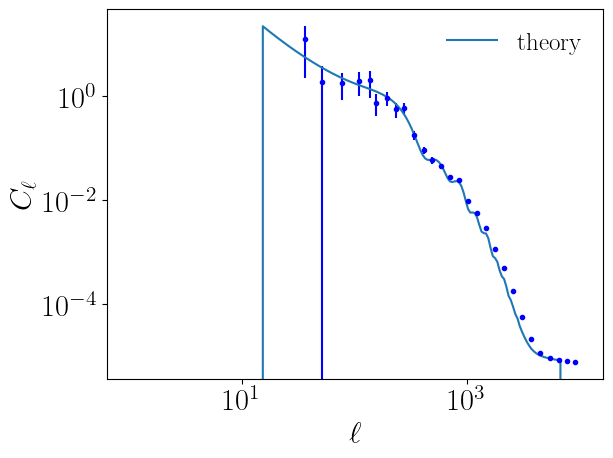

In [51]:
_,_,_ = baseMap.powerSpectrum(dataFourier=totalCmbFourier, plot=True, theory=[cmb.fCtotal])